# Twitter archive analysis in R
This performs some twitter archive analysis that is [based on this chapter of *Text Mining with R*](https://www.tidytextmining.com/twitter.html). 

For a start let's download/install all the required packages again:

In [1]:
install.packages("stringr")
library(stringr)

install.packages("tidytext")
library(tidytext)

library(httr)
library(lubridate)
library(ggplot2)
library(dplyr)
library(readr)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘dplyr’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Let's now get our access token and request our personal user object that will contain all of our data file downloads etc.:

In [2]:
access_token <- Sys.getenv("OH_ACCESS_TOKEN")
url <- paste("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token=",access_token,sep="")
resp <- GET(url)
user <- content(resp, "parsed")

Let's now look at the data sources we have on Open Humans:

In [ ]:
user$data

Let's now find the download URL for the Twitter archive from all files:

In [4]:
for (data_source in user$data){
    if (data_source$source == "direct-sharing-70"){
         twitter_archive_url <- data_source$download_url
    }
}

We can now create a temporary file that will contain the whole zipped Twitter archivee, from this we can then unzip and read the `tweets.csv` file:

In [5]:
temp <- tempfile()
download.file(twitter_archive_url,temp,method='wget')

#unzip(temp, list=TRUE) # this would list all files in the zip archive

data <- read_csv(unz(temp, "tweets.csv"))


Parsed with column specification:
cols(
  tweet_id = col_double(),
  in_reply_to_status_id = col_double(),
  in_reply_to_user_id = col_double(),
  timestamp = col_character(),
  source = col_character(),
  text = col_character(),
  retweeted_status_id = col_double(),
  retweeted_status_user_id = col_double(),
  retweeted_status_timestamp = col_character(),
  expanded_urls = col_character()
)


Now let's convert the timestamps into a proper format and plot a simple histogram of tweets over time:

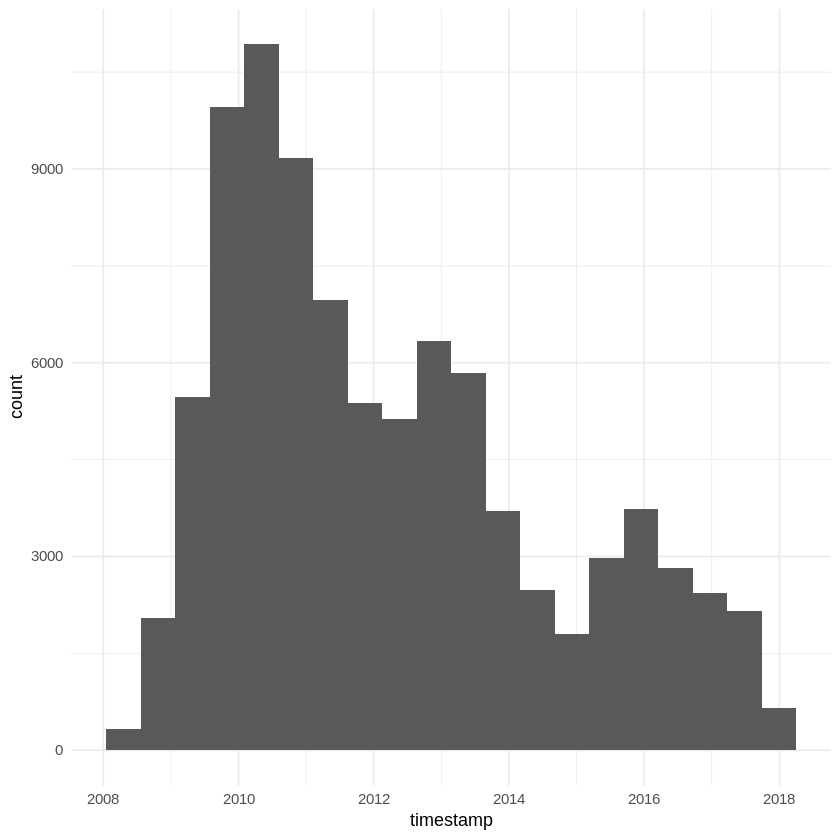

In [6]:
tweets <- mutate(data,timestamp = ymd_hms(timestamp))
ggplot(tweets, aes(x = timestamp)) +
  geom_histogram(position = "identity", bins = 20, show.legend = FALSE) + theme_minimal()

We can now tokenize the tweet texts, which will make it easier to work with and also allows us to easily calculate word frequencies in the next step: 

In [7]:
replace_reg <- "https://t.co/[A-Za-z\\d]+|http://[A-Za-z\\d]+|&amp;|&lt;|&gt;|RT|https"
unnest_reg <- "([^A-Za-z_\\d#@']|'(?![A-Za-z_\\d#@]))"
tidy_tweets <- tweets %>% 
  filter(!str_detect(text, "^RT")) %>%
  mutate(text = str_replace_all(text, replace_reg, "")) %>%
  unnest_tokens(word, text, token = "regex", pattern = unnest_reg) %>%
  filter(!word %in% stop_words$word,
         str_detect(word, "[a-z]"))

frequency <- tidy_tweets %>% 
  count(word, sort = TRUE) 
frequency$freq <- frequency$n / sum(frequency$n)

So, what's the top words I used over time: Yep, that would be the German equivalents of `I`, all the articles (`der, die, das`) along with `not` and `is`.

In [8]:
head(frequency)

word,n,freq
ich,17738,0.02313947
die,12828,0.01673431
das,12070,0.01574548
der,9141,0.01192456
nicht,8666,0.01130492
ist,8492,0.01107793


Let's now group the tweets by being "old" (pre-2013) and more recent ones (2013 or newer) to see whether the topics I tweet about have changed. After grouping we can calulcate the word-ratios and look at the most dividing and the most recent words:

In [9]:
library(tidyr)

tidy_tweets$date_group <- ifelse(tidy_tweets$timestamp < as.Date("2013-01-01"),"past","today")

word_ratios <- tidy_tweets %>%
  filter(!str_detect(word, "^@")) %>%
  count(word, date_group) %>%
  filter(sum(n) >= 10) %>%
  ungroup() %>%
  spread(date_group, n, fill = 0) %>%
  mutate_if(is.numeric, funs((. + 1) / sum(. + 1))) %>%
  mutate(logratio = log(past / today)) %>%
  arrange(desc(logratio))

word_ratios %>% 
  arrange(abs(logratio))

word,past,today,logratio
haha,2.092729e-04,2.093441e-04,-0.000340187
statt,1.351211e-04,1.354580e-04,-0.002489955
archives,2.471728e-05,2.462872e-05,0.003589091
feld,2.471728e-05,2.462872e-05,0.003589091
gedauert,2.471728e-05,2.462872e-05,0.003589091
gelt,2.471728e-05,2.462872e-05,0.003589091
gross,2.471728e-05,2.462872e-05,0.003589091
plain,2.471728e-05,2.462872e-05,0.003589091
tex,2.471728e-05,2.462872e-05,0.003589091
10k,1.647818e-05,1.641915e-05,0.003589091


We can see that some things, e.g. `archives` haven't changed much in frequency, as obvious from the small "odds" ratio that's close to zero. Outliers with a large positive values are those that were more frequent in the past, while outliers with values large negative values are more common in more recent tweets. To make it a bit more intuitive we can now plot the Top 15 words with the largest positive/negative odds ratio: 

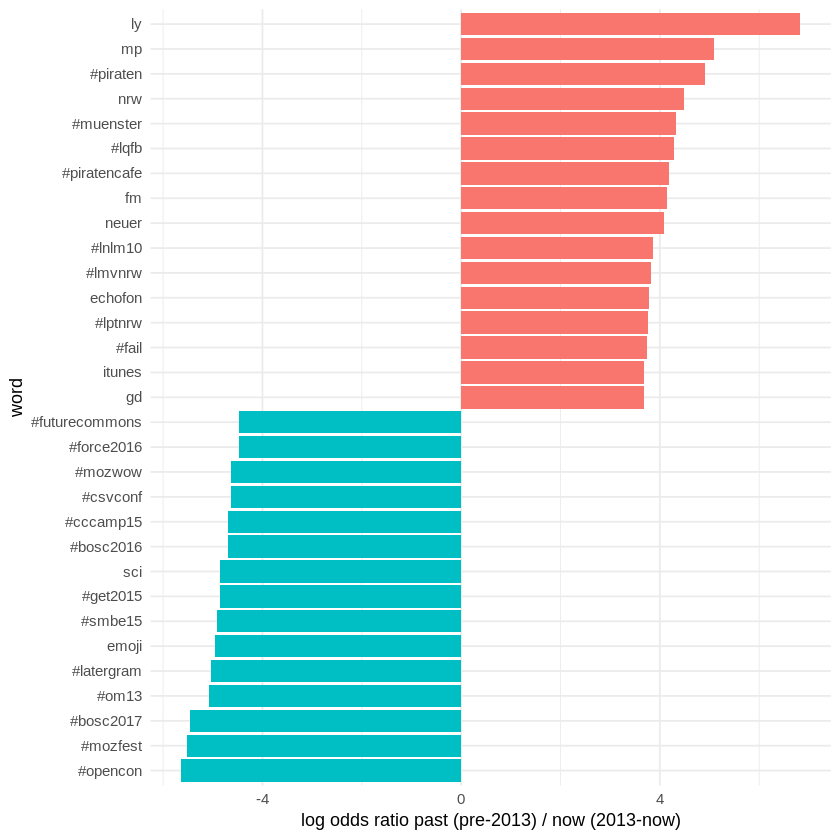

In [10]:
word_ratios %>%
  group_by(logratio < 0) %>%
  top_n(15, abs(logratio)) %>%
  ungroup() %>%
  mutate(word = reorder(word, logratio)) %>%
  ggplot(aes(word, logratio, fill = logratio < 0)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  ylab("log odds ratio past (pre-2013) / now (2013-now)") +
  scale_fill_discrete(name = "", labels = c("past", "now")) + theme_minimal()

What we see: My activity in the Pirate Party (and living in the state of North-Rhine Westphalia - short `NRW`) is clearly in the past and tweets about them occur mainly before 2013 - as demonstrated by hashtags like `#piraten, #lptnrw, #lmvnrw, #nrw` etc. My activity in the Open Science world is clearly still going strong in comparison: `#opencon, #mozfest, bosc201*, #csvconf` etc. are overrepresented. But what would happen if we excluded hashtags?

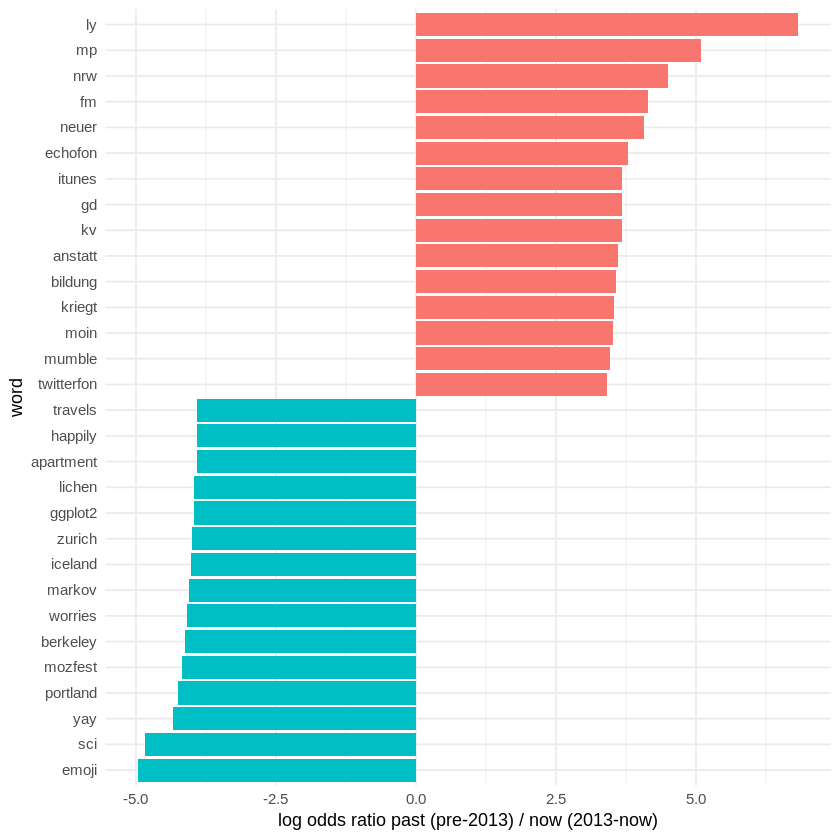

In [11]:
word_ratios %>%
  filter(!str_detect(word, "^#")) %>%
  group_by(logratio < 0) %>%
  top_n(15, abs(logratio)) %>%
  ungroup() %>%
  mutate(word = reorder(word, logratio)) %>%
  ggplot(aes(word, logratio, fill = logratio < 0)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  ylab("log odds ratio past (pre-2013) / now (2013-now)") +
  scale_fill_discrete(name = "", labels = c("past", "now")) + theme_minimal()

This looks a bit different, now older words are somewhat associated with the German language/dialects (`moin, kriegt, bildung, anstatt, neuer`) and random Top-Level-Domains that have fallen out of popularity (`ly, fm`) while the newer trends are 

- english speaking (`yay, travels, happily, worries`) 
- location based (`portland, berkeley, iceland, zurich`), fitting an increased travel compared to earlier times
- phd-related (`lichens, ggplot2, markov`) 
- and modern-ish inventions. `emoji` anyone? 😂

What will your twitter-archive and former past reveal?